# Task 3 — Customer Segmentation (RFM)
Compute Recency, Frequency, Monetary values and create RFM segments. Save results and visuals.

In [1]:
# Setup (run once)
!pip install --quiet pandas numpy matplotlib openpyxl scikit-learn
import os
import pandas as pd, numpy as np, matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 120
os.makedirs('/content/internship/data/raw', exist_ok=True)
os.makedirs('/content/internship/data/clean', exist_ok=True)
os.makedirs('/content/internship/images', exist_ok=True)
os.makedirs('/content/internship/reports', exist_ok=True)
print('Environment ready. Place datasets in /content/internship/data/raw or upload when prompted.')

Environment ready. Place datasets in /content/internship/data/raw or upload when prompted.


In [2]:
# Upload or ensure file at /content/internship/data/raw/online_retail.csv
path = '/content/internship/data/raw/online_retail.csv'
if not os.path.exists(path):
    from google.colab import files
    uploaded = files.upload()
    for fn in uploaded:
        open(path,'wb').write(uploaded[fn])
print('File:', path)

Saving online_retail_II.xlsx.zip to online_retail_II.xlsx (1).zip
File: /content/internship/data/raw/online_retail.csv


In [7]:
import zipfile

with zipfile.ZipFile('/content/online_retail_II.xlsx.zip', 'r') as z:
    z.extractall('/content/')

# Now read the Excel file (not CSV)
df = pd.read_excel('/content/online_retail_II.xlsx')
df.head()


,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


In [8]:
# Pre-clean
if 'InvoiceDate' in df.columns:
    df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
if 'InvoiceNo' in df.columns:
    df = df[~df['InvoiceNo'].astype(str).str.startswith('C')]
if 'CustomerID' in df.columns:
    df = df.dropna(subset=['CustomerID'])
if {'Quantity','UnitPrice'}.issubset(df.columns):
    df['Amount'] = df['Quantity'] * df['UnitPrice']
display(df.head())

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


In [11]:
print(df.columns.tolist())


['Invoice', 'StockCode', 'Description', 'Quantity', 'InvoiceDate', 'Price', 'Customer ID', 'Country']


In [12]:
import pandas as pd

# Compute Amount column
df['Amount'] = df['Quantity'] * df['Price']

# Snapshot date = 1 day after last transaction
snapshot_date = df['InvoiceDate'].max() + pd.Timedelta(days=1)

# Group by Customer ID
rfm = df.groupby('Customer ID').agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days,   # Recency
    'Invoice': 'nunique',                                     # Frequency
    'Amount': 'sum'                                           # Monetary
}).rename(columns={'InvoiceDate':'Recency',
                   'Invoice':'Frequency',
                   'Amount':'Monetary'})

# RFM Scoring
rfm['R_Score'] = pd.qcut(rfm['Recency'], 5, labels=[5,4,3,2,1])
rfm['F_Score'] = pd.qcut(rfm['Frequency'].rank(method='first'), 5, labels=[1,2,3,4,5])
rfm['M_Score'] = pd.qcut(rfm['Monetary'].rank(method='first'), 5, labels=[1,2,3,4,5])

# Segment & Score
rfm['RFM_Segment'] = rfm['R_Score'].astype(str) + rfm['F_Score'].astype(str) + rfm['M_Score'].astype(str)
rfm['RFM_Score'] = rfm[['R_Score','F_Score','M_Score']].astype(int).sum(axis=1)

rfm.head()


,Recency,Frequency,Monetary,R_Score,F_Score,M_Score,RFM_Segment,RFM_Score
Customer ID,,,,,,,,
12346.0,67,15,-64.68,3,5,1,351,9
12347.0,3,2,1323.32,5,2,4,524,11
12348.0,74,1,222.16,2,1,1,211,4
12349.0,43,4,2646.99,3,3,5,335,11
12351.0,11,1,300.93,5,1,2,512,8


In [13]:
# Simple segment naming
def segment_name(row):
    r,f,m = int(row['R_Score']), int(row['F_Score']), int(row['M_Score'])
    if r>=4 and f>=4 and m>=4: return 'Champions'
    if r>=4 and f>=3: return 'Loyal'
    if r<=2 and f>=4: return 'At Risk (High F)'
    if r<=2 and m<=2: return 'Dormant/Churn Risk'
    if f<=2 and m<=2: return 'Low Value'
    return 'Others'
rfm['Segment'] = rfm.apply(segment_name, axis=1)
display(rfm.head())

,Recency,Frequency,Monetary,R_Score,F_Score,M_Score,RFM_Segment,RFM_Score,Segment
Customer ID,,,,,,,,,
12346.0,67,15,-64.68,3,5,1,351,9,Others
12347.0,3,2,1323.32,5,2,4,524,11,Others
12348.0,74,1,222.16,2,1,1,211,4,Dormant/Churn Risk
12349.0,43,4,2646.99,3,3,5,335,11,Others
12351.0,11,1,300.93,5,1,2,512,8,Low Value


Saved RFM table to /content/internship/data/clean/rfm_table.csv


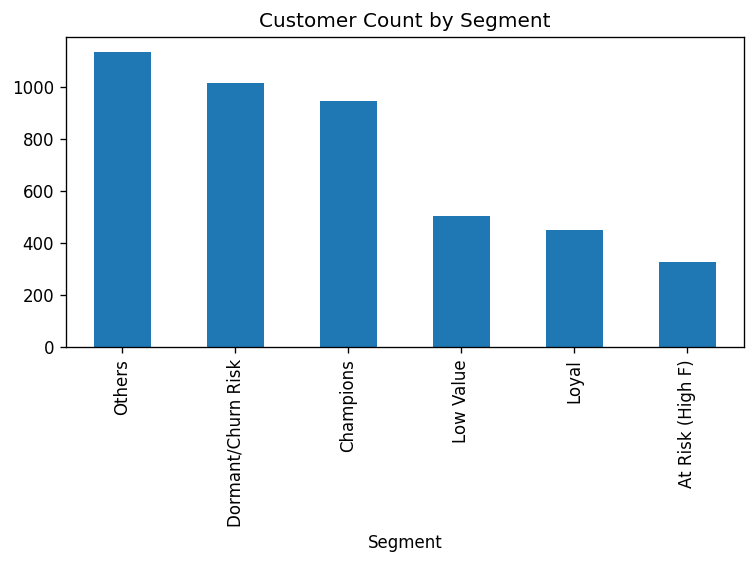

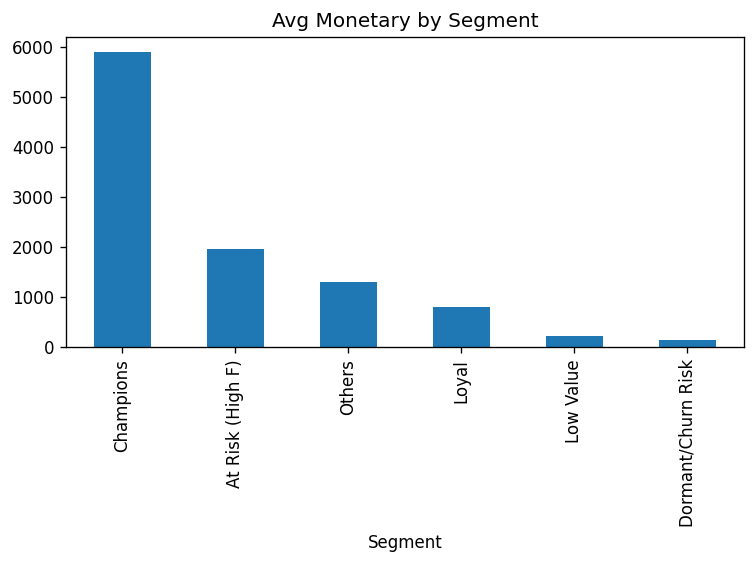

In [14]:
# Save outputs and plots
rfm.to_csv('/content/internship/data/clean/rfm_table.csv')
print('Saved RFM table to /content/internship/data/clean/rfm_table.csv')
import matplotlib.pyplot as plt
fig = plt.figure(); rfm['Segment'].value_counts().plot(kind='bar', title='Customer Count by Segment'); plt.tight_layout(); fig.savefig('/content/internship/images/t3_segment_counts.png', dpi=150); plt.show()
fig = plt.figure(); rfm.groupby('Segment')['Monetary'].mean().sort_values(ascending=False).plot(kind='bar', title='Avg Monetary by Segment'); plt.tight_layout(); fig.savefig('/content/internship/images/t3_monetary_by_segment.png', dpi=150); plt.show()

## Deliverables
- `rfm_table.csv` in `/content/internship/data/clean`
- Charts in `/content/internship/images`
- `reports/Task3_Report.md` for methods, segment definitions, and marketing actions